# Getting started with ODE Test Problems

## About this notebook

This Jupyter notebook is configured to run [Octave](https://octave.org/) commands. Press `Shift + Enter` To run each cell and go the next. 
The latest version of `ODE Test Problems (OTP)` is automatically pulled from its [Github repository](https://github.com/ComputationalScienceLaboratory/ODE-Test-Problems.git). We just need to add the package to the path:

In [1]:
addpath(genpath('../../ODE-Test-Problems'))

In [35]:
graphics_toolkit("plotly")

In [36]:
displayformat('Octave')

ans = 


## Lorenz63 test problem 

The Lorenz63 test problem, introduced by mathematician Edward Lorenz in 1963 to study the behavior of a simple system of differential equations, is a classic problem in chaos theory. It consists of three ordinary differential equations that describe the behavior of a simplified atmospheric convection system. The following are the equations:

\begin{align}
\frac{dx}{dt} &= σ(y - x), \\
\frac{dy}{dt} &= x(ρ - z) - y, \\
\frac{dz}{dt} &= xy - βz.
\end{align}
where $x$, $y$, and $z$ are variables that represent the state of the system at a given time, and σ, ρ, and β are parameters that control the behavior of the system.


Let's create the Lorenz63 problem and solve it using the default parameters and intial conditions:

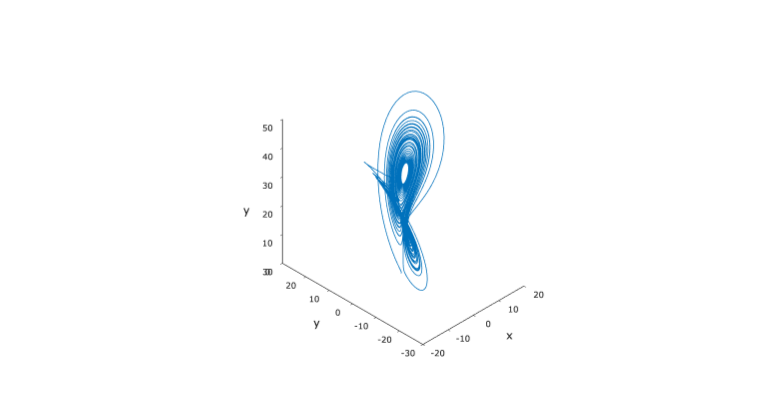

In [31]:
% Create a problem object
problem = otp.lorenz63.presets.Canonical;

% Solve the problem
sol = problem.solve('RelTol', 1e-10);

% Plot the solution
problem.plotPhaseSpace(sol);

The `problem` object contains a number of useful properties including:

* `Name`: The name of the problem
* `NumVars`: Number of variables in the state vector
* `Parameters`: Vector of problem-specific parameters that can be modified 
* `RHS` : The Right-hand-side structure inlcludes the ODE right-hand-side function and possibly Jacobians, splittings, etc. (depending on the test problem)
* `TimeSpan`: Timespan of the integration
* `Y0`: Initial condition 


## Changing the parameters of a problem

The parameters of a model are stored as properties in the problem object:

In [19]:
problem = otp.kpr.presets.Canonical;
problem.Parameters

ans =   otp.kpr.KPRParameters object with properties:

      Lambda: [2x2 double]
       Omega: [1x1 double]


You can directly change parameters and solve the mdodel again:

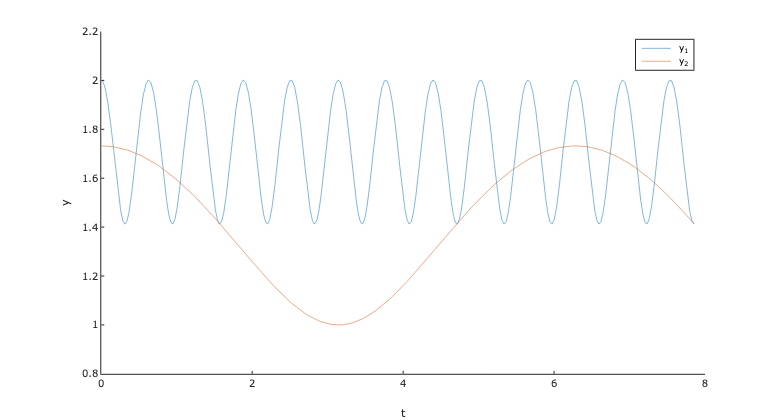

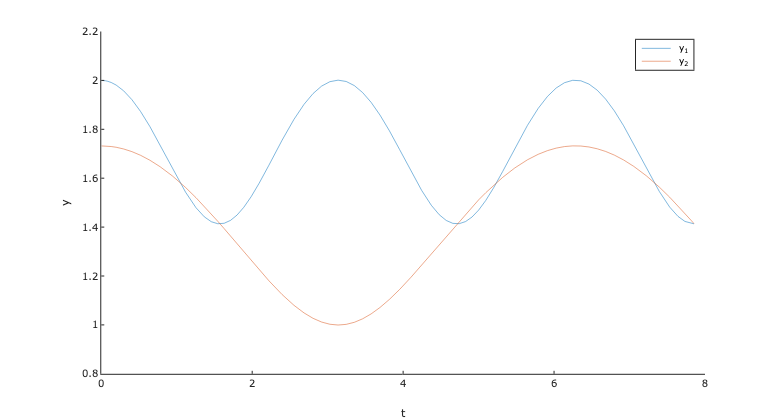

In [20]:
problem.Parameters.Omega = 10;
sol1 =  problem.solve();

problem.Parameters.Omega = 2;
sol2 = problem.solve();

problem.plot(sol1), title('KPR - \Omega = 10')
problem.plot(sol2), title('KPR - \Omega = 2')

## Plotting solutions 

`OTP` has built-in plotting capabilities for visualizing the computed problem solution.  For small problems it is possible to plot the solution trajectory using the `plot` function. 

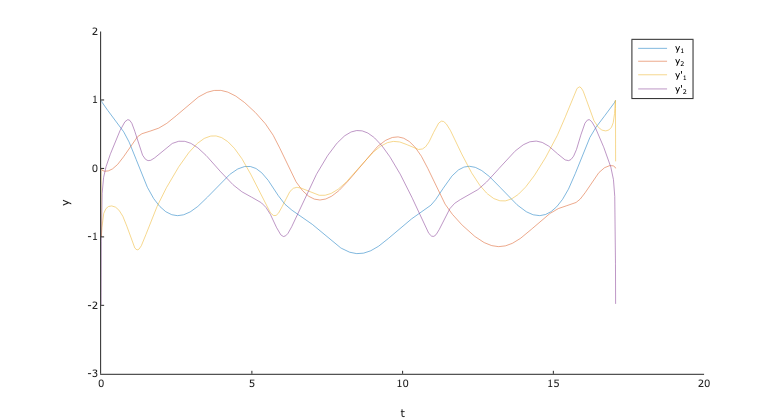

In [16]:
# Create the Arenstorf orbit problem
problem = otp.arenstorf.presets.Canonical;

# Compute the solution
sol = problem.solve('RelTol', 1e-10);

# Create solution plot
problem.plot(sol)

The `plotPhaseSpace ` function creates a phase-space diagram by visualizing all spatial-components of the state vector:

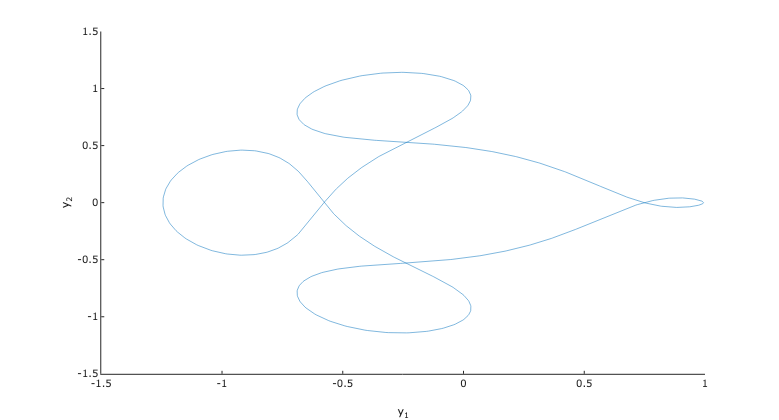

In [6]:
problem.plotPhaseSpace(sol)

## Exploring presets 

Each test problem comes with a number of `presets` that feature different characterstics in the solution of the initial value problem. As an example, The `Brusselator` test problem has *decaying, spiral, and  periodic* `presets`:

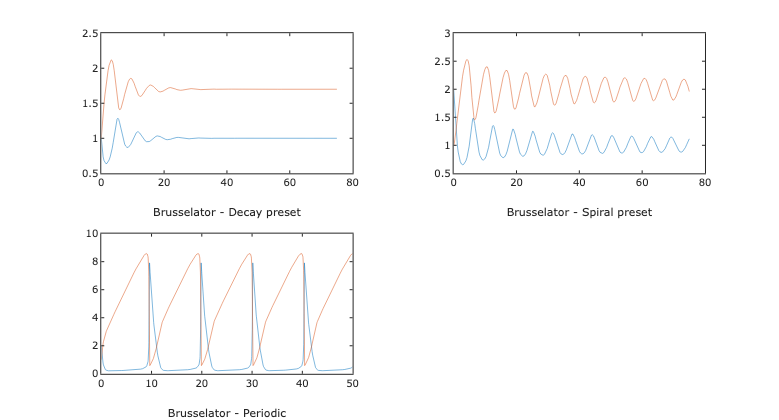

fatal: caught signal Aborted -- stopping myself...

In [21]:
subplot(2,2,1);
problem = otp.brusselator.presets.Decay();
sol = problem.solve('RelTol', 1e-6);
plot(sol.x, sol.y)
xlabel('Brusselator - Decay preset')

subplot(2,2,2);
problem = otp.brusselator.presets.Spiral();
sol = problem.solve('RelTol', 1e-6);
plot(sol.x, sol.y)
xlabel('Brusselator - Spiral preset')

subplot(2,2,3);
problem = otp.brusselator.presets.Periodic();
sol = problem.solve('RelTol', 1e-6);
plot(sol.x, sol.y)
xlabel('Brusselator - Periodic')

## Changing the solver

The choice of ODE solver for the test problems is flexible. Here, we will use the *Explicit* time-stepping method `ode45` to solve the `Robertson` problem:

In [35]:
% Create a problem object
problem          = otp.robertson.presets.Canonical();
problem.TimeSpan = [0,5];

We will pass the right-hand-side function, timespan of the integration, and the initial condition to `ode45`:

In [36]:
tic
sol = ode45(problem.RHS.F, problem.TimeSpan, problem.Y0);
toc

Elapsed time is 3.08477 seconds.


Since this is a stiff problem, the explicit solver takes a long time to finish the integration. For a faster result, we can use the *Implicit* ODE solver `ode23s` and provide it with the Jacobian of the right-hand-side: 

In [37]:
tic
sol = ode23s(problem.RHS.F, problem.TimeSpan, problem.Y0, odeset('Jacobian', problem.RHS.Jacobian));
toc

Elapsed time is 0.0469949 seconds.


# List of ODE Test Problems

You can use any of the problems using the template command

`model = otp.{problem name}.presets.{Preset name};`

Here is a table of test problems currently implemented in `OTP`. A default `{Preset name}` for all implemented problems is `Canonical`. Other presets are specific to each test problem.

| Test Problem       | Description                                                                                         |
|--------------------|-----------------------------------------------------------------------------------------------------|
| allencahn          | The Allen-Cahn equation models phase separation and pattern formation.                               |
| ascherlineardae    | A linear advection-diffusion equation used to study numerical stability.                            |
| arenstorf          | The Arenstorf orbit problem models a spacecraft's trajectory around the moon.                        |
| bouncingball       | A simple bouncing ball model used to study event detection and simulation.                           |
| brusselator        | The Brusselator is a simple model for chemical reactions that exhibits oscillatory behavior.         |
| cusp               | The cusp equation models a system with a fold bifurcation.                                           |
| e5                 | A set of differential equations describing a predator-prey model with spatial interactions.         |
| hires              | A set of differential equations used to study high-dimensional chaos and long-term integration.     |
| inverterchain      | A chain of inverters used to study coupled oscillators.                                              |
| kpr                | The KPR model is used to study pattern formation in chemical reactions.?                              |
| lienard            | The Lienard equation models a system with a Hopf bifurcation.                                        |
| lorenz63           | The Lorenz 63 system is a simple model for atmospheric convection that exhibits chaotic behavior.    |
| lorenz96           | A set of differential equations used to study atmospheric dynamics and chaos.                       |
| lotkavolterra      | A set of differential equations modeling population dynamics in predator-prey systems.             |
| nbody              | A set of differential equations describing the motion of N interacting point masses.               |
| oregonator         | The Oregonator model is a set of differential equations used to study oscillatory behavior.         |
| pendulum           | The simple pendulum equation models the motion of a swinging pendulum.                               |
| protherorobinson   | The Prothero-Robinson system is used to study the stability of numerical schemes.                   |
| quadratic          | A simple quadratic model used to study numerical methods for ODEs.                                   |
| robertson          | The Robertson reaction model is a set of differential equations used to study chemical kinetics.     |
| sanzserna          | A set of differential equations used to study numerical methods for DAEs.                           |
| torus              | The torus equation models the motion of a point on a torus.                                           |
| transistoramplifier | A set of differential equations modeling the behavior of a common emitter transistor amplifier circuit. |
| trigonometricdae   | A set of differential-algebraic equations used to study numerical methods for DAEs.                 |
| vanderpol          | The van der Pol oscillator models the behavior of an electronic oscillator.                          |


## Inverse Problem

In [64]:
model = otp.lorenz63.presets.Canonical
model.Parameters.Sigma
sol   = model.solve('RelTol', 1e-8);
disp(sol.y(:,end)')

model =   otp.lorenz63.presets.Canonical object with properties:

            Name: Lorenz Equations
         NumVars: [1x1 double]
      Parameters: [1x1 otp.lorenz63.Lorenz63Parameters]
             RHS: [1x1 otp.RHS]
        TimeSpan: [2x1 double]
              Y0: [3x1 double]


ans = 10


   11.836   17.299   24.000


In [60]:
function final_state = fwd_model(sig)

    model = otp.lorenz63.presets.Canonical;
    model.Parameters.Sigma = sig;
    sol = model.solve('RelTol', 1e-8);
    final_state = sol.y(:,end);
    
end

In [65]:
costFun = @(sig) norm( fwd_model(sig) - [11.84; 17.30; 24.00] );

In [88]:
[x, ~, info] = fminsearch(costFun, 11, optimset() )

Exceeded maximum number of function evaluations


x = 13.750


info = 0


fatal: caught signal Aborted -- stopping myself...

In [84]:
fminunc

: fminunc ( fcn , x0 ) ¶ 
 : fminunc ( fcn , x0 , options ) ¶ 
 : [ x , fval , info , output , grad , hess ] = fminunc ( fcn , …) ¶ 
 Solve an unconstrained optimization problem defined by the function
 fcn .
 
 fminunc attempts to determine a vector x such that
 fcn ( x ) is a local minimum.
 
 fun is a function handle, inline function, or string containing the
name of the function to evaluate. fcn should accept a vector (array)
defining the unknown variables, and return the objective function value,
optionally with gradient.
 
 x0 determines a starting guess. The shape of x0 is preserved in
all calls to fcn , but otherwise is treated as a column vector.
 
 options is a structure specifying additional parameters which
control the algorithm. Currently, fminunc recognizes these options:
 "AutoScaling" , "FinDiffType" , "FunValCheck" ,
 "GradObj" , "MaxFunEvals" , "MaxIter" ,
 "OutputFcn" , "TolFun" , "TolX" , "TypicalX" .
 
 If "AutoScaling" is "on" , the variables will be
automatically scaled according to the column norms of the (estimated)
Jacobian. As a result, "TolFun" becomes scaling-independent. By
default, this option is "off" because it may sometimes deliver
unexpected (though mathematically correct) results.
 
 If "GradObj" is "on" , it specifies that fcn —when
called with two output arguments—also returns the Jacobian matrix of
partial first derivatives at the requested point.
 
 "MaxFunEvals" proscribes the maximum number of function evaluations
before optimization is halted. The default value is
 100 * number_of_variables , i.e., 100 * length ( x0 ) .
The value must be a positive integer.
 
 "MaxIter" proscribes the maximum number of algorithm iterations
before optimization is halted. The default value is 400.
The value must be a positive integer.
 
 "TolX" specifies the termination tolerance for the unknown variables
 x , while "TolFun" is a tolerance for the objective function
value fval . The default is 1e-6 for both options.
 
 For a description of the other options,
see ‘ optimset ’.
 
 On return, x is the location of the minimum and fval contains
the value of the objective function at x .
 
 info may be one of the following values:
 
 
 1 
 Converged to a solution point. Relative gradient error is less than
specified by TolFun .
 
 
 2 
 Last relative step size was less than TolX .
 
 
 3 
 Last relative change in function value was less than TolFun .
 
 
 0 
 Iteration limit exceeded—either maximum number of algorithm iterations
 MaxIter or maximum number of function evaluations MaxFunEvals .
 
 
 -1 
 Algorithm terminated by OutputFcn .
 
 
 -3 
 The trust region radius became excessively small.
 
 

 Optionally, fminunc can return a structure with convergence
statistics ( output ), the output gradient ( grad ) at the
solution x , and approximate Hessian ( hess ) at the solution
 x .
 
 Application Notes: If the objective function is a single nonlinear equation
of one variable then using fminbnd is usually a better choice.
 
 The algorithm used by fminunc is a gradient search which depends
on the objective function being differentiable. If the function has
discontinuities it may be better to use a derivative-free algorithm such as
 fminsearch .
 
 See also: fminbnd, fminsearch, optimset.

In [86]:
fminsearch?

: x = fminsearch ( fun , x0 ) ¶ 
 : x = fminsearch ( fun , x0 , options ) ¶ 
 : x = fminsearch ( problem ) ¶ 
 : [ x , fval , exitflag , output ] = fminsearch (…) ¶ 
 
 Find a value of x which minimizes the multi-variable function
 fun .
 
 fun is a function handle, inline function, or string containing the
name of the function to evaluate.
 
 The search begins at the point x0 and iterates using the
Nelder & Mead Simplex algorithm (a derivative-free method). This
algorithm is better-suited to functions which have discontinuities or for
which a gradient-based search such as fminunc fails.
 
 Options for the search are provided in the parameter options using the
function optimset . Currently, fminsearch accepts the options:
 "Display" , "FunValCheck" , "MaxFunEvals" ,
 "MaxIter" , "OutputFcn" , "TolFun" , "TolX" .
 
 "MaxFunEvals" proscribes the maximum number of function evaluations
before optimization is halted. The default value is
 200 * number_of_variables , i.e., 200 * length ( x0 ) .
The value must be a positive integer.
 
 "MaxIter" proscribes the maximum number of algorithm iterations
before optimization is halted. The default value is
 200 * number_of_variables , i.e., 200 * length ( x0 ) .
The value must be a positive integer.
 
 For a description of the other options,
see ‘ optimset ’. To initialize an options structure
with default values for fminsearch use
 options = optimset ("fminsearch") .
 
 fminsearch may also be called with a single structure argument
with the following fields:
 
 
 objective 
 The objective function.
 
 
 x0 
 The initial point.
 
 
 solver 
 Must be set to "fminsearch" .
 
 
 options 
 A structure returned from optimset or an empty matrix to
indicate that defaults should be used.
 
 

 The field options is optional. All others are required.
 
 On exit, the function returns x , the minimum point, and fval ,
the function value at the minimum.
 
 The third output exitflag reports whether the algorithm succeeded and
may take one of the following values:
 
 
 1 
 if the algorithm converged
(size of the simplex is smaller than TolX AND the step in
function value between iterations is smaller than TolFun ).
 
 
 0 
 if the maximum number of iterations or the maximum number of function
evaluations are exceeded.
 
 
 -1 
 if the iteration is stopped by the "OutputFcn" .
 
 

 The fourth output is a structure output containing runtime
about the algorithm. Fields in the structure are funcCount 
containing the number of function calls to fun , iterations 
containing the number of iteration steps, algorithm with the name of
the search algorithm (always:
 "Nelder-Mead simplex direct search" ), and message 
with the exit message.
 
 Example:
 
 
 fminsearch (@(x) (x(1)-5).^2+(x(2)-8).^4, [0;0])
 

 Note: If you need to find the minimum of a single variable function it is
probably better to use fminbnd .
 
 See also: fminbnd, fminunc, optimset.